## Problem: Time-Fractional Diffusion Equation

We solve the equation:

$$
\frac{\partial^\alpha u(x, t)}{\partial t^\alpha} = \kappa \frac{\partial^2 u(x, t)}{\partial x^2}
$$

with:

- **Gaussian initial condition**: $u(x,0) = e^{-(x-x_0)^2/(2\sigma^2)}$
- **Dirichlet boundary conditions**: $u(-L/2,t) = 0$, $u(L/2,t) = 0$
- **Caputo fractional derivative** of order $\alpha$


In [1]:
# Step 1: Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.display import display, Markdown
import time
from scipy.integrate import quad
import scipy.special as sp


# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.size'] = 12

In [2]:
#Parameters
alpha = 0.5      # Fractional order (0 < α ≤ 1)
kappa = 0.5      # Diffusion coefficient
L = 2.0          # Domain length: [-L/2, L/2] = [-1, 1]
T = 0.1          # Final time

# Discretization parameters
M = 100          # Number of spatial points
N = 100          # Number of time steps

# Gaussian parameters
x0 = 0.0         # Center of Gaussian
sigma = 0.2      # Width of Gaussian
A = 1.0          # Amplitude

In [3]:
#Spatial and Temporal grids
h = L / (M-1)          # Spatial step size
tau = T / N              # Time step size
x = np.linspace(-L/2, L/2, M)  # Spatial grid
t = np.linspace(0, T, N+1)     # Temporal grid

# Gamma function value for the L1 scheme
Gamma_alpha = math.gamma(2 - alpha)

# Discretization parameter μ
mu = kappa * (tau**alpha) * Gamma_alpha / (h**2)

print("\nGrid parameters:")
print(f"Spatial step h = {h:.6f}")
print(f"Time step τ = {tau:.6f}")
print(f"Γ(2-α) = {Gamma_alpha:.6f}")
print(f"Discretization parameter μ = {mu:.6f}")


Grid parameters:
Spatial step h = 0.020202
Time step τ = 0.001000
Γ(2-α) = 0.886227
Discretization parameter μ = 34.334074


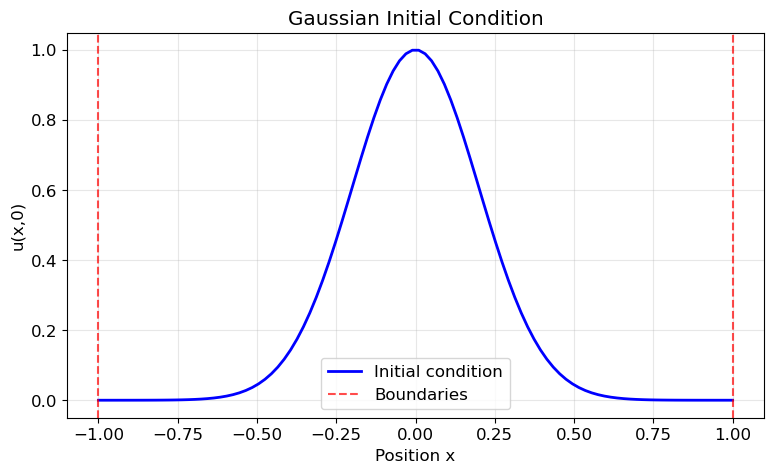

Initial condition: max(u(x,0)) = 0.998725
Initial mass: 0.501325


In [4]:
# Gaussian initial condition
def initial_condition(x, x0=0.0, sigma=0.2, A=1.0):
    """Gaussian initial condition: u(x,0) = A * exp(-(x-x0)²/(2σ²))"""
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Dirichlet boundary conditions (homogeneous)
def boundary_conditions(t):
    """u(-L/2,t) = 0, u(L/2,t) = 0"""
    return 0.0, 0.0

# Set initial condition
u_initial = initial_condition(x, x0, sigma, A)
u_initial[0] = 0.0
u_initial[-1] = 0.0

# Plot initial condition
plt.plot(x, u_initial, 'b-', linewidth=2, label='Initial condition')
plt.axvline(-L/2, color='red', linestyle='--', alpha=0.7, label='Boundaries')
plt.axvline(L/2, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Position x')
plt.ylabel('u(x,0)')
plt.title('Gaussian Initial Condition')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Initial condition: max(u(x,0)) = {np.max(u_initial):.6f}")
print(f"Initial mass: {np.trapz(u_initial, x):.6f}")

In [5]:
# L1 scheme coefficients for Caputo derivative
def compute_L1_coefficients(n, alpha):
    """
    Compute L1 coefficients b_j for time step n
    b_j = (j+1)¹⁻ᵅ - j¹⁻ᵅ for j = 0, 1, ..., n-1
    """
    b = np.zeros(n)
    for j in range(n):
        b[j] = (j + 1)**(1 - alpha) - j**(1 - alpha)
    return b

In [6]:
def thomas_algorithm(a, b, c, d):
    """
    Thomas algorithm for solving tridiagonal system Ax = d
    
    Parameters:
    a: lower diagonal (length n)
    b: main diagonal (length n)  
    c: upper diagonal (length n)
    d: right-hand side (length n)
    
    Returns:
    x: solution (length n)
    """
    n = len(d)
    a = a.astype(float)
    b = b.astype(float)
    c = c.astype(float)
    d = d.astype(float)
    
    # forward
    c_prime = np.zeros(n, dtype=float)
    d_prime = np.zeros(n, dtype=float)
    
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]
    
    for i in range(1, n):
        denom = b[i] - a[i] * c_prime[i-1]
        c_prime[i] = c[i] / denom if i < n - 1 else 0.0
        d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denom
    
    
    # Back substitution
    x = np.zeros(n, dtype=float)
    x[-1] = d_prime[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x

In [7]:
def solve_time_step(u_prev, H, mu, a_tn, b_tn):
    """
    Solve one time step of the fractional diffusion equation
    
    Parameters:
    u_prev: solution at previous time step
    H: historical term
    mu: discretization parameter
    a_tn, b_tn: boundary conditions at current time
    
    Returns:
    u_new: solution at new time step
    """
    n_points = len(u_prev)
    
    # Matrix coefficients for interior points
    a = -mu * np.ones(n_points)           # lower diagonal
    b = (1 + 2 * mu) * np.ones(n_points)      # main diagonal
    c = -mu * np.ones(n_points)           # upper diagonal
    a[0] = 0
    c[n_points-1] = 0
    
    # Right-hand side
    d = H.copy()
    
    # Apply boundary conditions
    d[0] += mu * a_tn      # from left boundary u₀ = a(tₙ)
    d[-1] += mu * b_tn     # from right boundary u_M = b(tₙ)
    
    # Solve using Thomas algorithm
    u_new = thomas_algorithm(a, b, c, d)
    
    return u_new

In [8]:
def solve_fractional_diffusion(alpha, kappa, L, T, M, N, x0, sigma, A):
    """
    Complete solver for time-fractional diffusion equation
    """
    # Start timing
    start_time = time.time()
    
    # Initialize solution array
    u = np.zeros((M, N+1))
    
    # Set up grid and parameters
    h = L / (M - 1)
    tau = T / N
    x = np.linspace(-L/2, L/2, M)
    Gamma_alpha = math.gamma(2 - alpha)
    mu = kappa * (tau**alpha) * Gamma_alpha / (h**2)

    # Set initial condition
    u[:, 0] = initial_condition(x, x0, sigma, A)
    
    
    # Time stepping loop
    for n in range(1, N+1):
        
        # Get boundary conditions at current time
        current_time = n * tau
        a_tn, b_tn = boundary_conditions(current_time)
        
        # Compute historical term H_i^n
        H = np.zeros(M)
        if n == 1:
            H[1:-1]=u[1:-1,0]
        else:
            b_coeffs = compute_L1_coefficients(n, alpha)
                
            for i in range(M-1):  # For all spatial points
                hist_sum = 0.0
                for j in range(0,n-1):
                    hist_sum += b_coeffs[j] * (u[i, n - j-1] - u[i, n - j - 2])
                H[i] = u[i, n - 1] - hist_sum
        
        u[:,n] = solve_time_step(u[:,n-1], H, mu, a_tn, b_tn)
    
    
    # End timing
    end_time = time.time()
    computation_time = end_time - start_time
    
    print(f"\nComputation completed in {computation_time:.2f} seconds")
    
    return x, np.linspace(0, T, N+1), u

In [9]:
# Plot solution at different times
def plot_solution_times(x, u,t, time_indices, title):
    """Plot solution at specific time indices"""
    
    for idx in time_indices:
        t_val = t[idx]
        if idx == 0:
            label = f't = 0.000 (Initial)'
        elif idx == len(t) - 1:
            label = f't = {t_val:.3f} (Final)'
        else:
            label = f't = {t_val:.3f}'
        
        plt.plot(x, u[:, idx], linewidth=2, label=label)
    
    plt.xlabel('Position x')
    plt.ylabel('Solution u(x,t)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [10]:
x_sol1, t_sol1, u_sol1 = solve_fractional_diffusion(alpha=1, kappa=0.5, L=2.0, T=0.1, M=200, N=100, x0=0.0, sigma=0.2, A=1.0)


Computation completed in 0.66 seconds


In [11]:
x_sol7, t_sol7, u_sol7 = solve_fractional_diffusion(alpha=0.7, kappa=0.5, L=2.0, T=0.1, M=200, N=100, x0=0.0, sigma=0.2, A=1.0)


Computation completed in 0.64 seconds


In [12]:
x_sol5, t_sol5, u_sol5 = solve_fractional_diffusion(alpha=0.5, kappa=0.5, L=2.0, T=0.1, M=200, N=100, x0=0.0, sigma=0.2, A=1.0)


Computation completed in 0.68 seconds


In [13]:
x_sol3, t_sol3, u_sol3 = solve_fractional_diffusion(alpha=0.3, kappa=0.5, L=2.0, T=0.1, M=200, N=100, x0=0.0, sigma=0.2, A=1.0)


Computation completed in 0.61 seconds


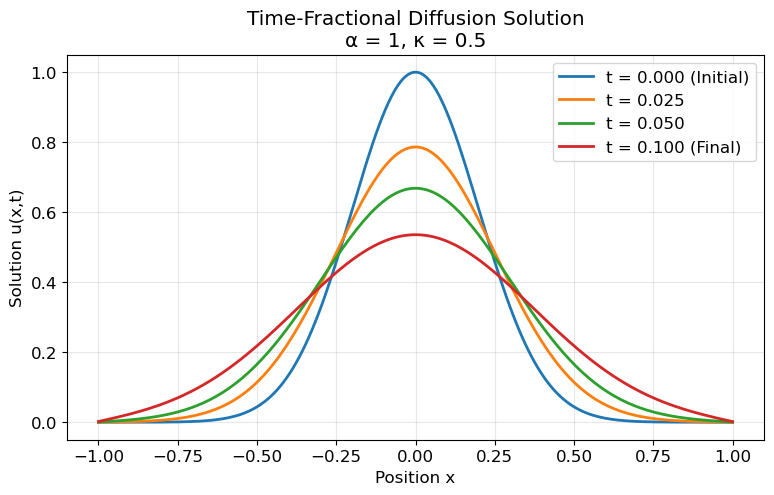

In [14]:
# Plot for alpha = 1
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol1, u_sol1,t_sol1, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {1}, κ = {kappa}')

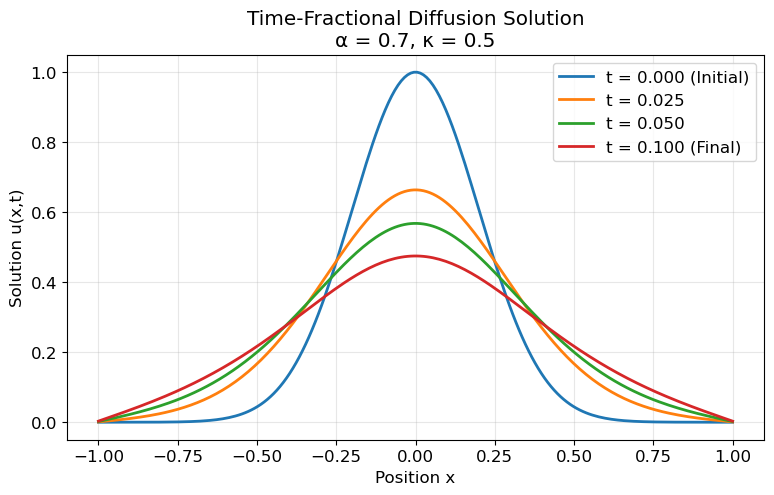

In [15]:
# Plot for alpha = 0.7
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol7, u_sol7,t_sol7, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {0.7}, κ = {kappa}')

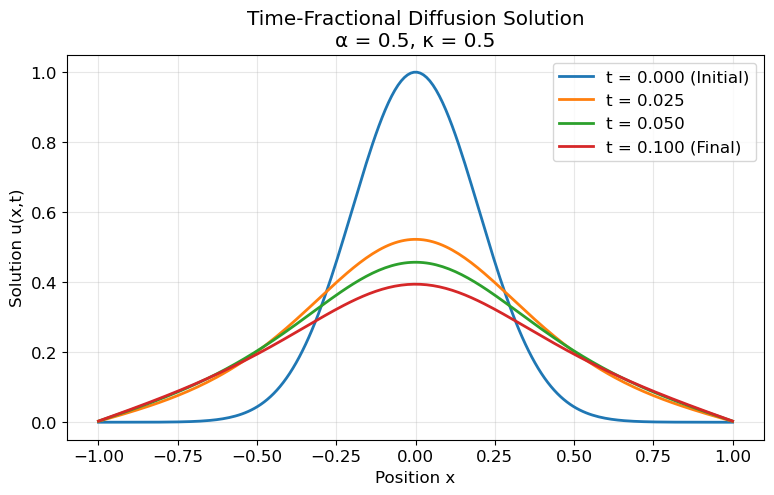

In [16]:
# Plot for alpha = 0.5
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol5, u_sol5,t_sol5, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {0.5}, κ = {kappa}')

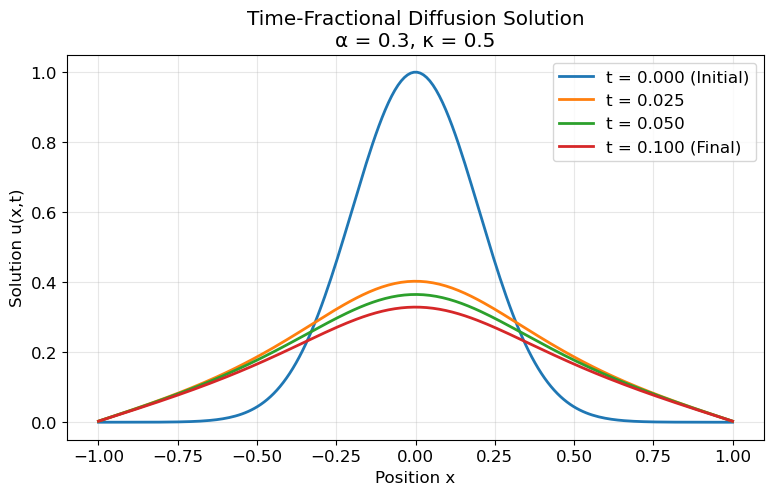

In [17]:
# Plot for alpha = 0.3
time_indices = [0, N//4,N//2,N]
plot_solution_times(x_sol3, u_sol3,t_sol3, time_indices, 
                   f'Time-Fractional Diffusion Solution\nα = {0.3}, κ = {kappa}')

In [18]:
def exact_fourier_solution(x, t, kappa, x0=0.0, sigma=0.2, A=1.0, L=2.0, n_terms=100):
    """
    CORRECTED Fourier series solution for diffusion equation on [-L/2, L/2]
    with homogeneous Dirichlet boundary conditions u(-L/2,t) = u(L/2,t) = 0
    """
    if t == 0:
        return A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    solution = np.zeros_like(x)
    
    for n in range(1, n_terms + 1):
        # Proper wave number for domain [-L/2, L/2]
        k_n = n * np.pi / L
        
        # Proper eigenvalue
        lambda_n = (n * np.pi / L)**2
        
        # Proper eigenfunction sin(k_n * (x + L/2))
        # This satisfies: sin(k_n * (-L/2 + L/2)) = sin(0) = 0
        # and sin(k_n * (L/2 + L/2)) = sin(nπ) = 0
        
        def integrand(x_val):
            initial = A * np.exp(-(x_val - x0)**2 / (2 * sigma**2))
            return initial * np.sin(k_n * (x_val + L/2))
        
        # Integration over correct domain
        B_n, _ = quad(integrand, -L/2, L/2)
        B_n *= 2 / L  # Proper normalization
        
        # Add term to solution
        solution += B_n * np.exp(-kappa * lambda_n * t) * np.sin(k_n * (x + L/2))
    
    return solution

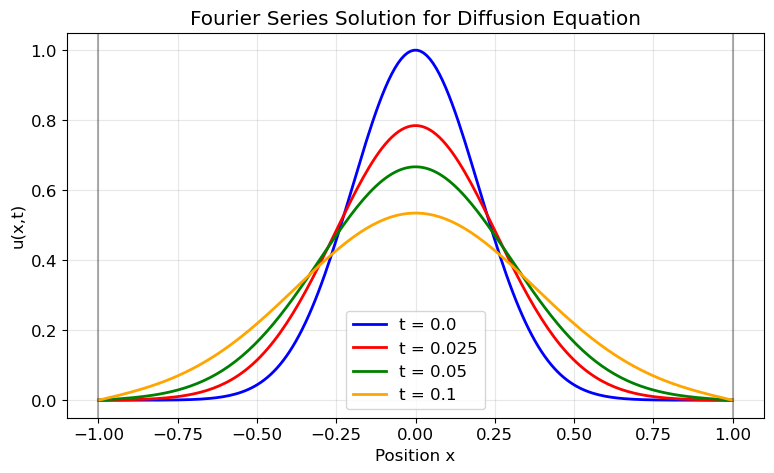

In [19]:
t_values = [0.0, 0.025, 0.050, 0.1]
colors = ['blue', 'red', 'green', 'orange']
n_terms = 100

for t_val, color in zip(t_values, colors):
    u_corrected = exact_fourier_solution(x, t_val, kappa, x0, sigma, A, L, n_terms)
    plt.plot(x, u_corrected, color=color, linewidth=2, label=f't = {t_val}')

plt.xlabel('Position x')
plt.ylabel('u(x,t)')
plt.title('Fourier Series Solution for Diffusion Equation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(-L/2, color='k', linestyle='-', alpha=0.3)
plt.axvline(L/2, color='k', linestyle='-', alpha=0.3)
plt.show()

In [20]:
# Mass conservation analysis
def analyze_mass_conservation(x, u, t):
    """Analyze mass conservation over time"""
    mass = np.zeros(len(t))
    for n in range(len(t)):
        mass[n] = np.trapz(u[:, n], x)
    
    plt.plot(t, mass, 'b-', linewidth=2)
    plt.xlabel('Time t')
    plt.ylabel('Total Mass ∫u(x,t)dx')
    plt.title('Mass Conservation Analysis')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial mass: {mass[0]:.6f}")
    print(f"Final mass: {mass[-1]:.6f}")
    print(f"Mass change: {abs(mass[-1] - mass[0]):.6e}")
    print(f"Relative mass change: {abs(mass[-1] - mass[0])/mass[0]:.6e}")

# Maximum value analysis
def analyze_maximum_values(u,t):
    """Analyze how the maximum value evolves over time"""
    max_vals = np.max(u, axis=0)
    

    plt.semilogy(t, max_vals, 'r-', linewidth=2)
    plt.xlabel('Time t')
    plt.ylabel('Maximum Value max(u(x,t))')
    plt.title('Evolution of Maximum Value (Log Scale)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial maximum: {max_vals[0]:.6f}")
    print(f"Final maximum: {max_vals[-1]:.6f}")
    print(f"Decay factor: {max_vals[-1]/max_vals[0]:.6f}")

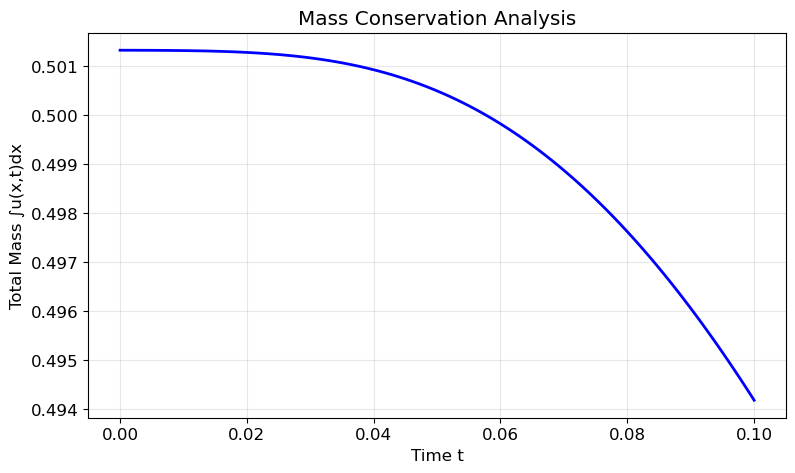

Initial mass: 0.501325
Final mass: 0.494180
Mass change: 7.145167e-03
Relative mass change: 1.425255e-02


In [22]:
analyze_mass_conservation(x_sol1, u_sol1,t_sol1)

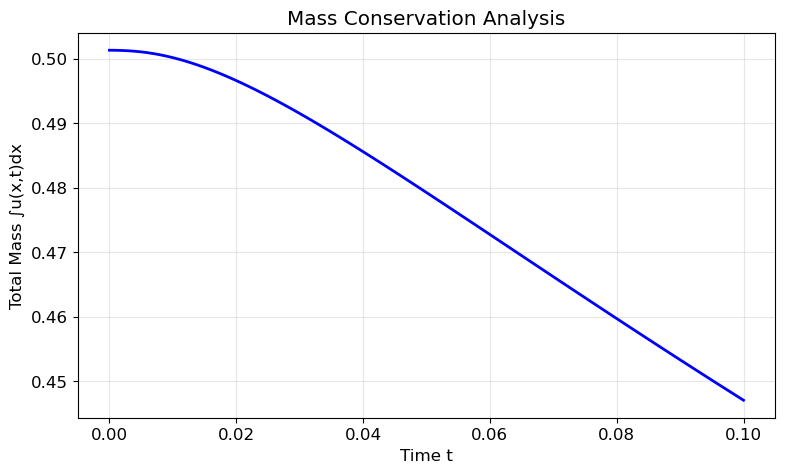

Initial mass: 0.501325
Final mass: 0.447084
Mass change: 5.424138e-02
Relative mass change: 1.081960e-01


In [23]:
analyze_mass_conservation(x_sol7, u_sol7,t_sol7)

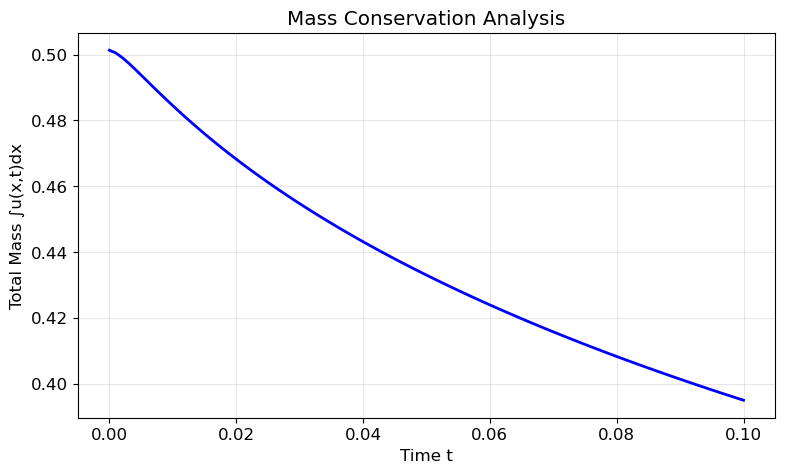

Initial mass: 0.501325
Final mass: 0.394930
Mass change: 1.063950e-01
Relative mass change: 2.122275e-01


In [21]:
analyze_mass_conservation(x_sol5, u_sol5,t_sol5)

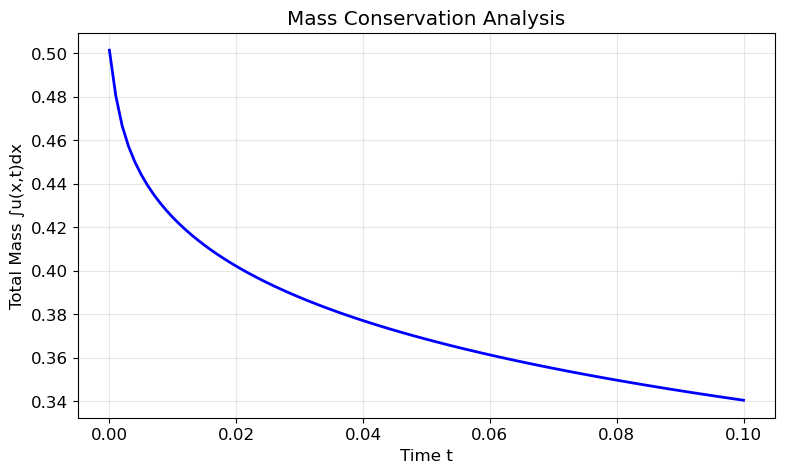

Initial mass: 0.501325
Final mass: 0.340400
Mass change: 1.609252e-01
Relative mass change: 3.209995e-01


In [24]:
analyze_mass_conservation(x_sol3, u_sol3,t_sol3)

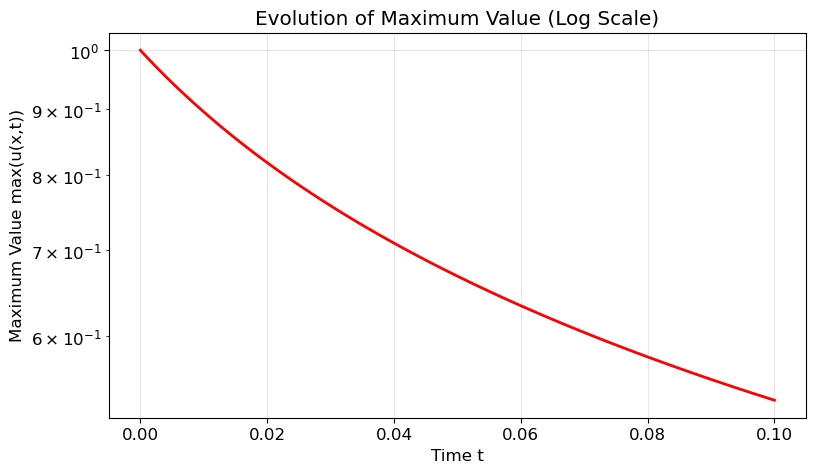

Initial maximum: 0.999684
Final maximum: 0.535530
Decay factor: 0.535699


In [25]:
analyze_maximum_values(u_sol1,t_sol1)

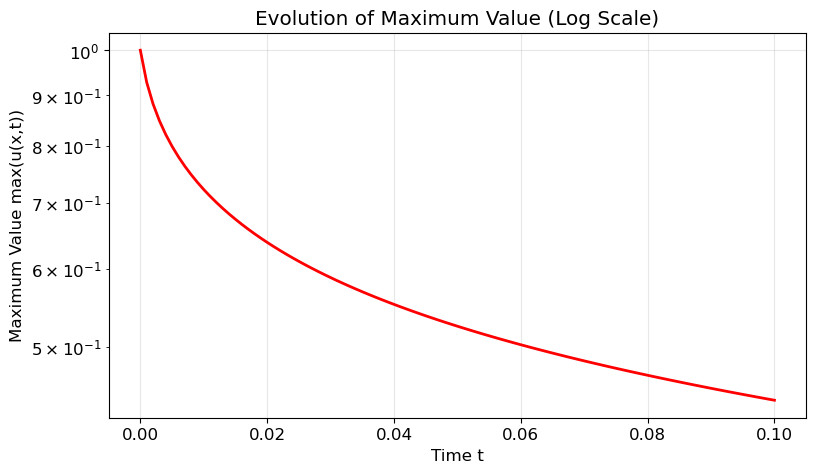

Initial maximum: 0.999684
Final maximum: 0.441294
Decay factor: 0.441433


In [26]:
analyze_maximum_values(u_sol7,t_sol7)

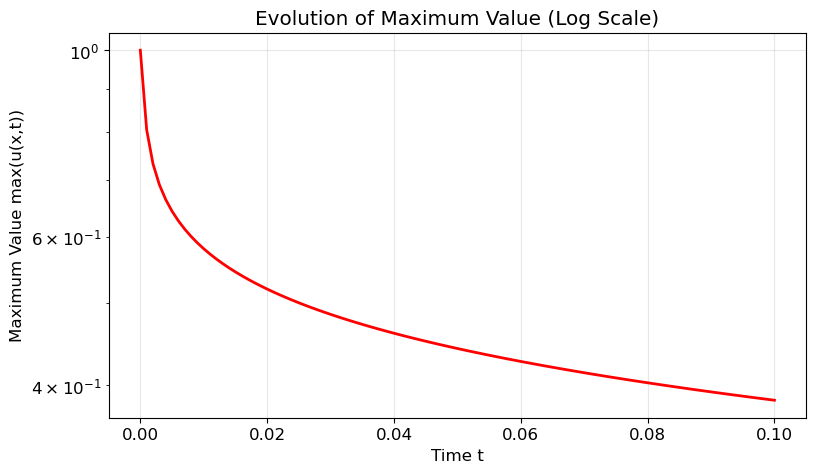

Initial maximum: 0.999684
Final maximum: 0.383564
Decay factor: 0.383685


In [27]:
analyze_maximum_values(u_sol5,t_sol5)

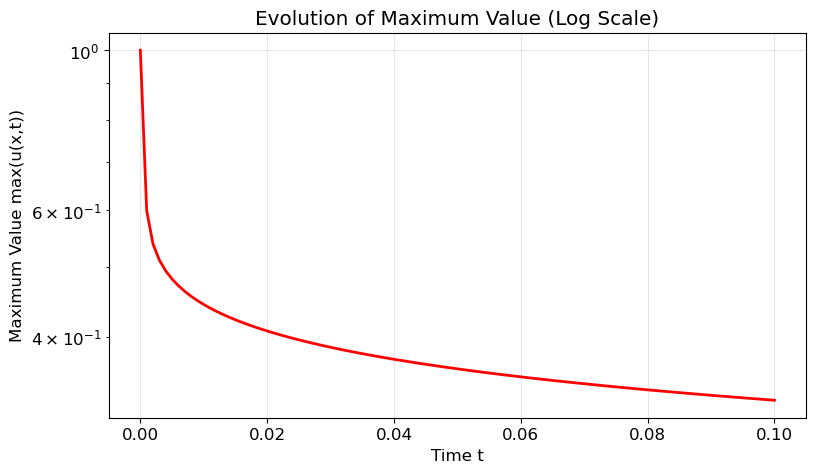

Initial maximum: 0.999684
Final maximum: 0.326411
Decay factor: 0.326514


In [28]:
analyze_maximum_values(u_sol3,t_sol3)

## Compare solutions for different fractional orders α

In [69]:
def compare_different_alpha(t_sp):
    """Compare solutions for different fractional orders α"""
    alphas = [0.3, 0.5, 0.7, 0.9, 1.0]
    solutions = []
    
    for alpha_comp in alphas:
        print(f"Solving for α = {alpha_comp}...")
        x_sol, t_sol, u_comp = solve_fractional_diffusion(alpha_comp, kappa, L, t_sp, M, N, x0, sigma, A)
        solutions.append(u_comp)
        
        # Plot final time solution
        plt.plot(x_sol, u_comp[:, -1], linewidth=2, 
                label=f'α = {alpha_comp}')
    
    plt.xlabel('Position x')
    plt.ylabel('Solution u(x,T)')
    plt.title(f'Comparison of Different α Values at t = {t_sp}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return alphas, solutions

Solving for α = 0.3...

Computation completed in 0.55 seconds
Solving for α = 0.5...

Computation completed in 0.54 seconds
Solving for α = 0.7...

Computation completed in 0.51 seconds
Solving for α = 0.9...

Computation completed in 0.51 seconds
Solving for α = 1.0...

Computation completed in 0.49 seconds


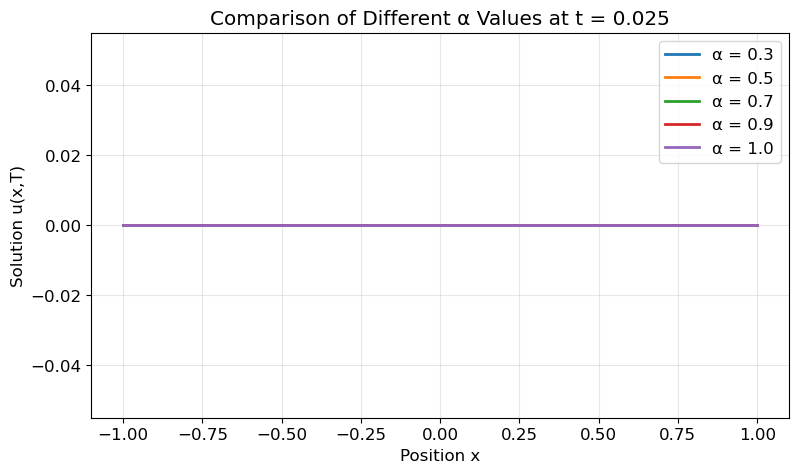

In [70]:
#At t = 0.025
alphas_comp, solutions_comp = compare_different_alpha(0.025)

Solving for α = 0.3...

Computation completed in 0.73 seconds
Solving for α = 0.5...

Computation completed in 0.82 seconds
Solving for α = 0.7...

Computation completed in 0.71 seconds
Solving for α = 0.9...

Computation completed in 0.74 seconds
Solving for α = 1.0...

Computation completed in 0.73 seconds


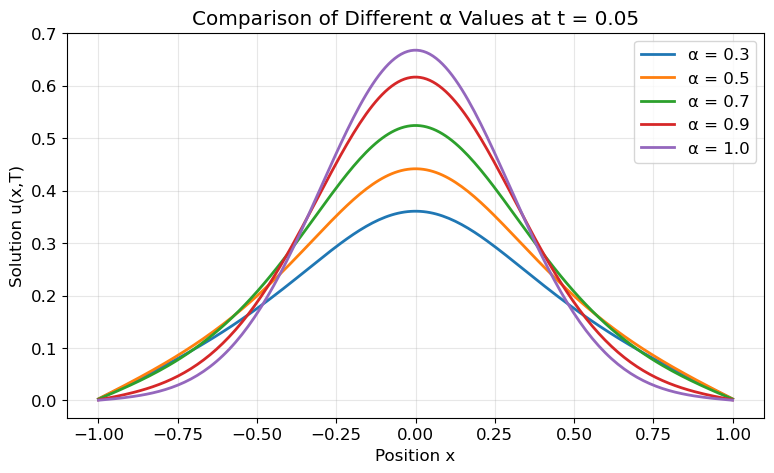

In [37]:
#At t = 0.05
alphas_comp, solutions_comp = compare_different_alpha(0.05)

Solving for α = 0.3...

Computation completed in 0.58 seconds
Solving for α = 0.5...

Computation completed in 0.57 seconds
Solving for α = 0.7...

Computation completed in 0.53 seconds
Solving for α = 0.9...

Computation completed in 0.51 seconds
Solving for α = 1.0...

Computation completed in 0.52 seconds


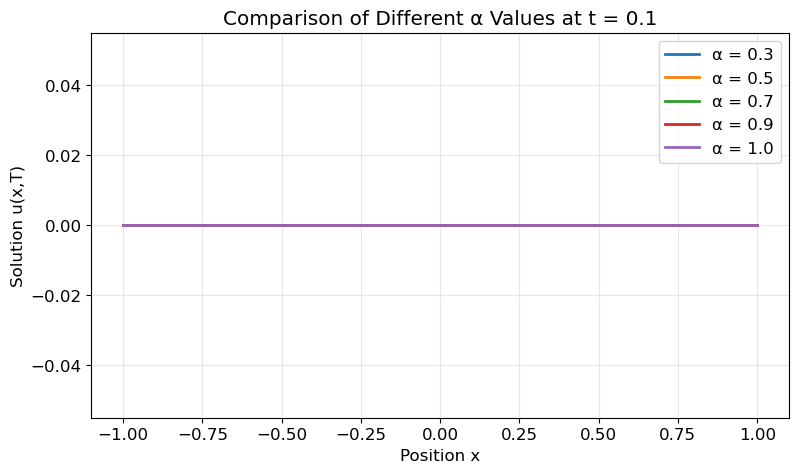

In [71]:
#At t = 0.1
alphas_comp, solutions_comp = compare_different_alpha(0.1)

In [44]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [48]:
def corrected_fractional_solver(alpha, kappa, L, T, M, N, x0=0.0, sigma=0.2, A=1.0):
    """
    CORRECTED fractional diffusion solver
    """
    # Grid setup (same as before)
    h = L / (M - 1)
    tau = T / N
    x = np.linspace(-L/2, L/2, M)
    Gamma_alpha = math.gamma(2 - alpha)
    mu = kappa * (tau**alpha) * Gamma_alpha / (h**2)
    
    # Initialize
    u = np.zeros((M, N+1))
    u[:, 0] = A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    print(f"Solving for α={alpha}, μ={mu:.6f}")
    
    for n in range(1, N+1):
        # CORRECTED: Compute historical term
        H = np.zeros(M)
        
        if n == 1:
            # First time step: H = u^{0}
            H[1:-1] = u[1:-1, 0]
        else:
            # CORRECTED HISTORICAL TERM CALCULATION
            b = np.zeros(n)
            for j in range(n):
                b[j] = (j+1)**(1-alpha) - j**(1-alpha)
            
            for i in range(1, M-1):
                hist_sum = 0.0
                # CORRECTED: Sum from j=0 to n-2 (NOT j=1 to n-1)
                for j in range(0, n-1):  # THIS IS THE KEY FIX
                    hist_sum += b[j] * (u[i, n-1-j] - u[i, n-2-j])
                
                # CORRECTED FORMULA
                H[i] = u[i, n-1] - hist_sum
        
        # Solve tridiagonal system
        n_interior = M - 2
        main_diag = (1 + 2 * mu) * np.ones(n_interior)
        off_diag = -mu * np.ones(n_interior - 1)
        
        A_mat = diags([off_diag, main_diag, off_diag], [-1, 0, 1], format='csc')
        u_interior = spsolve(A_mat, H[1:-1])
        
        # Update solution
        u[0, n] = 0.0
        u[-1, n] = 0.0
        u[1:-1, n] = u_interior
        
        # Debug output
        if n <= 3:  # Show first few steps
            peak = np.max(u[:, n])
            print(f"  Step {n}: peak = {peak:.6f}, avg_H = {np.mean(H):.6f}")
    
    final_peak = np.max(u[:, -1])
    print(f"α={alpha}: Final peak = {final_peak:.6f}")
    return u

# Test the correction
print("RUNNING CORRECTED SOLVER:")
test_alphas = [0.3, 1.0]

for alpha in test_alphas:
    u_corrected = corrected_fractional_solver(alpha, 0.5, 2.0, 0.1, 200, 100)

RUNNING CORRECTED SOLVER:
Solving for α=0.3, μ=566.248952
  Step 1: peak = 0.598461, avg_H = 0.249409
  Step 2: peak = 0.598461, avg_H = 0.249409
  Step 3: peak = 0.537733, avg_H = 0.245350
α=0.3: Final peak = 0.327881
Solving for α=1.0, μ=4.950125
  Step 1: peak = 0.987644, avg_H = 0.249409
  Step 2: peak = 0.976020, avg_H = 0.249409
  Step 3: peak = 0.964788, avg_H = 0.249409
α=1.0: Final peak = 0.535529
